In [63]:
%%capture
!pip install category_encoders==2.*
# !pip install pdpbox
!pip install shap


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, roc_auc_score, roc_curve, RocCurveDisplay, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [32]:
# more info on datasets can be found: https://www.kaggle.com/code/mur418/2020-fantasy-football

In [48]:
# using three different types of models, which one is the best to predict which features are best for a running back's fantasy football position?

In [33]:
# data clean
# read in csv for just rb's
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fantasy_football_datasets/rb_stats_and_projections.csv')

# change cols to lower and replace spaces with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')

# drop null values
df.dropna(inplace=True)

# create subset for only 2020 stats
mask = df[[col for col in df.columns if '2020' in col]]
df = mask

# create fm and tv
# want to predict total fantasy points
target = '2020_fpts'
X = df.drop(columns = target)
y = df[target]


<Axes: >

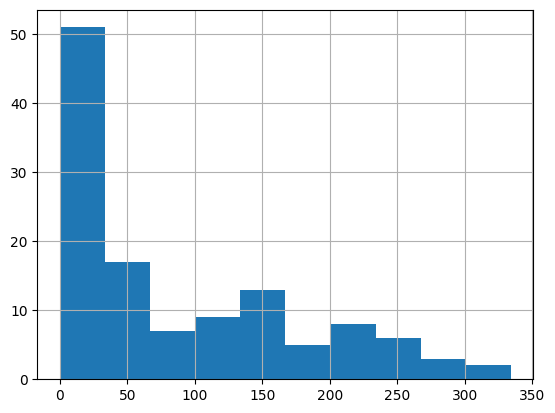

In [34]:
# check target vairbale for skewness
y.hist()

In [35]:
# check skewness
y.skew(axis = 0, skipna = True)

0.8958220366954868

In [36]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

In [58]:
# get mean absolute error
y_pred = [y_train.mean()] * len(y_train)
mae_first = mean_absolute_error(y_train, y_pred)
print('mean absolute error:', mae_first)

mean absolute error: 74.76348958333334


In [38]:
# make models and fit train data to them
model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=42, n_jobs =-1)
model_xgb = XGBRegressor(random_state=42, n_jobs = -1)

In [39]:
model_lr.fit(X_train, y_train);
model_rf.fit(X_train, y_train);
model_xgb.fit(X_train, y_train);

In [47]:
# create function to run all models at once
def check_metrics(model):
  print('Training MAE: ', mean_absolute_error(y_train, model.predict(X_train)))
  print('VAL MAE: ', mean_absolute_error(y_val, model.predict(X_val)))
  print('VAL Rˆ2: ', model.score(X_val, y_val))
  print()
  print()

models = [model_lr, model_rf, model_xgb]

for m in models:
  check_metrics(m)

# linear regression model has best val mae so go with that

Training MAE:  1.4430094265450581
VAL MAE:  1.504676372341226
VAL Rˆ2:  0.9995141096087578


Training MAE:  2.6070788194444248
VAL MAE:  7.754261333333323
VAL Rˆ2:  0.9773302480316945


Training MAE:  0.024711223940054487
VAL MAE:  9.937081906127926
VAL Rˆ2:  0.9727413620554479




Text(0.5, 1.0, 'Linear Regression Coefs')

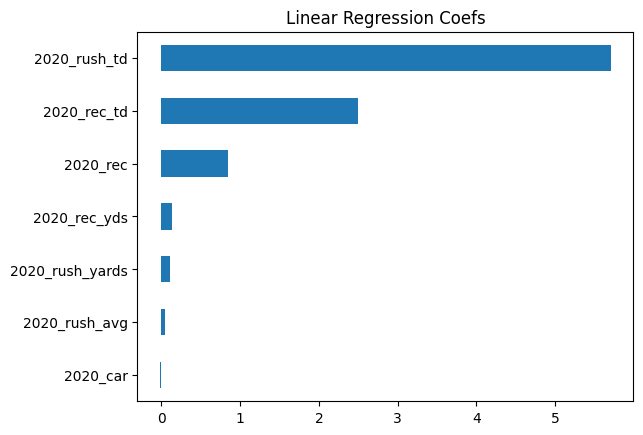

In [49]:
# get metrics from linear regression model
coefficients = model_lr.coef_
coef = pd.DataFrame(data = coefficients, index = X_train.columns, columns = ['coefficients'])
coef['coefficients'].sort_values().plot(kind = 'barh')
plt.title('Linear Regression Coefs')

In [50]:
coef['coefficients'].sort_values(key = abs, ascending=False)

# rush td and rec td are the top features for total points for a rb
# total receptions is the third most important feature for a rb

2020_rush_td       5.707285
2020_rec_td        2.490862
2020_rec           0.847771
2020_rec_yds       0.135055
2020_rush_yards    0.103721
2020_rush_avg      0.049185
2020_car          -0.017234
Name: coefficients, dtype: float64

In [52]:
# do this again but balance the data since it is clearly skewed to the right
# transform data

y_train_log = np.log1p(y_train)
model_lr.fit(X_train, y_train_log)
y_pred_log = model_lr.predict(X_val)
y_pred_reg = np.expm1(y_pred_log)

In [59]:
# get MAE now with transformed data

lr_mae = mean_absolute_error(y_val, y_pred_reg)
print("first mae:", mae_first)
print("mae with transformed data:", lr_mae)

# MAE was about 3 less than our baseline!

first mae: 74.76348958333334
mae with transformed data: 71.94167725071851


In [60]:
# run same model fucntion but with transformed training data
model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=42, n_jobs =-1)
model_xgb = XGBRegressor(random_state=42, n_jobs = -1)


model_lr.fit(X_train, y_train_log);
model_rf.fit(X_train, y_train_log);
model_xgb.fit(X_train, y_train_log);

model_rf.fit(X_train, y_train_log)
y_rf_pred_log = model_rf.predict(X_val)
y_rf_pred_reg = np.expm1(y_rf_pred_log)
rf_mae = mean_absolute_error(y_val, y_rf_pred_reg)


model_xgb.fit(X_train, y_train_log)
y_xbg_pred_log = model_xgb.predict(X_val)
y_xgb_pred_reg = np.expm1(y_xbg_pred_log)
xgb_mae = mean_absolute_error(y_val, y_xgb_pred_reg)

print('LR MAE: ', lr_mae)
print('RF MAE: ', rf_mae)
print('XBG MAE: ', xgb_mae)

# RF model has the best MAE

LR MAE:  71.94167725071851
RF MAE:  8.350749093669316
XBG MAE:  9.752120644378662


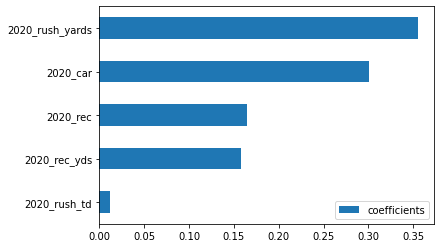

In [ ]:
# get feature importances for RF cause its the best performing model
rf_coefs = model_rf.feature_importances_
rf_coef = pd.DataFrame(data = rf_coefs, index = X_train.columns, columns = ['coefficients'])
rf_coef.sort_values(by ='coefficients').tail().plot(kind = 'barh')

# looks like rushing yards, amount of carries are the top 2 features influencing total points
# this contradicts linear regression model which had rushing td as most important coef

In [ ]:
rf_coef['coefficients'].sort_values(ascending = False)
# can see receptions are more important than recept yards

2020_rush_yards    0.355226
2020_car           0.301057
2020_rec           0.164658
2020_rec_yds       0.157670
2020_rush_td       0.011621
2020_rush_avg      0.006583
2020_rec_td        0.003186
Name: coefficients, dtype: float64

In [ ]:
# according to random forest model, top three features for a rb in 2020: rush_yards --> number of carries --> number of receptions
# rushing tds are 5th most important feature, interesting...
# reception tds are the least important feature, again interesting....

In [ ]:
# which model is better to go with? linear regression model saying rb most importnat features for points in the 2020 season are: rushing and reception tds and total number of receptions